## Repeated measure/longitudinal analysis (Random intercept model)

In [1]:
#install.packages('readr')
#install.packages('tidyverse')
#install.packages('compositions')

In [2]:
library(readr)
library(tidyverse)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ dplyr   1.0.7
✔ tibble  3.1.4     ✔ stringr 1.4.0
✔ tidyr   1.1.3     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [3]:
# load taxonomy
otu_data = read_tsv("/Users/dagmarschierova/MEGA/MBÚ/USTEK/NGS/output/qiime2_results_B_plus_HC/taxonomy_ustek_no_raref/taxonomy-L7-rel-filtered1perc.tsv", skip = 1)
otu_id = otu_data$`#OTU ID`
otu_data = data.frame(otu_data[, -1], check.names = FALSE)
rownames(otu_data) = otu_id

# load metadata
meta_data = read_tsv("/Users/dagmarschierova/MEGA/MBÚ/USTEK/NGS/input/metadata_ustek_new.tsv")[-1, ]
meta_data = meta_data %>% rename(Sample.ID = `#SampleID`)

#source("https://raw.githubusercontent.com/FrederickHuangLin/ANCOM/master/scripts/ancom_v2.1.R")
source("/Users/dagmarschierova/MEGA/MBÚ/TNF/NGS/scripts/Ancom_paired_modif.R")

Rows: 99 Columns: 71

── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (71): #SampleID, Label, Patient, Age, Sex, Height, Weight, BMI, BMI_cate...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following objects are masked from ‘package:stats’:

    anova, cor, cov, dist, var


The following objects are masked from ‘package:base’:

    %*%, norm, scale, scale.default




## HC vs IBD

In [5]:
# Step 1: Data preprocessing

feature_table = otu_data; sample_var = "Sample.ID"; group_var = "Disease_status"
out_cut = 0.05; zero_cut = 0.90; lib_cut = 0; neg_lb = TRUE
prepro = feature_table_pre_process(feature_table, meta_data, sample_var, group_var, 
                                   out_cut, zero_cut, lib_cut, neg_lb)
feature_table = prepro$feature_table # Preprocessed feature table
meta_data = prepro$meta_data # Preprocessed metadata
struc_zero = prepro$structure_zeros # Structural zero info

In [6]:
# Step 2: ANCOM
options("expressions"=500000)

main_var = "Disease_status"; p_adj_method = "BH"; alpha = 0.05
adj_formula = NULL; rand_formula = "~ 1 | Patient"
control = lmeControl(maxIter = 100, msMaxIter = 100, opt = "optim")
t_start = Sys.time()
res = ANCOM(feature_table, meta_data, struc_zero, main_var, p_adj_method, 
            alpha, adj_formula, rand_formula, control = control)
t_end = Sys.time()
t_run = t_end - t_start # around 30s

write.table(res$out, file="/Users/dagmarschierova/MEGA/MBÚ/USTEK/NGS/output/qiime2_results_B_plus_HC/taxonomy_ustek_no_raref/ANCOM2_L7-rel-Health_status.tsv",
           quote=FALSE, sep='\t', row.names = FALSE)
write.table(res$dat_fig, file="/Users/dagmarschierova/MEGA/MBÚ/USTEK/NGS/output/qiime2_results_B_plus_HC/taxonomy_ustek_no_raref/ANCOM2_L7-rel-datfig-Health_status.tsv",
           quote=FALSE, sep='\t', row.names = FALSE)


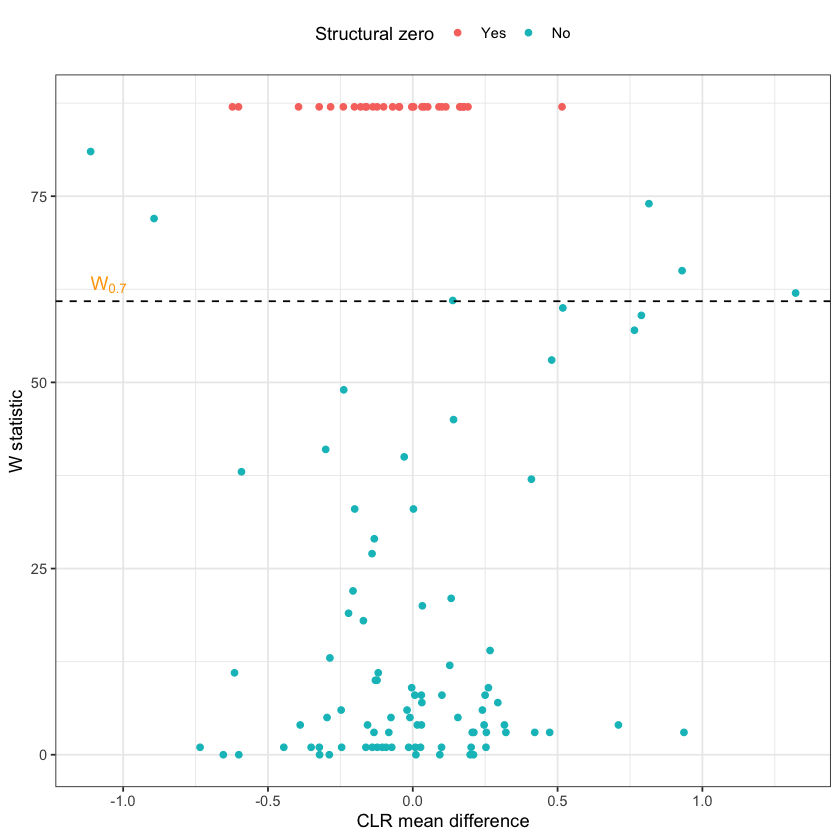

In [7]:
# Step 3: Volcano Plot

# Number of taxa except structural zeros
n_taxa = ifelse(is.null(struc_zero), nrow(feature_table), sum(apply(struc_zero, 1, sum) == 0))
# Cutoff values for declaring differentially abundant taxa
cut_off = c(0.9 * (n_taxa -1), 0.8 * (n_taxa -1), 0.7 * (n_taxa -1), 0.6 * (n_taxa -1))
names(cut_off) = c("detected_0.9", "detected_0.8", "detected_0.7", "detected_0.6")

# Annotation data
dat_ann = data.frame(x = min(res$fig$data$x), y = cut_off["detected_0.7"], label = "W[0.7]")

fig = res$fig + 
  geom_hline(yintercept = cut_off["detected_0.7"], linetype = "dashed") + 
  geom_text(data = dat_ann, aes(x = x, y = y, label = label), 
            size = 4, vjust = -0.5, hjust = 0, color = "orange", parse = TRUE)
fig  

In [8]:
#png(filename="/Users/dagmarschierova/MEGA/MBÚ/USTEK/NGS/output/qiime2_results_B_plus_HC/taxonomy_ustek_no_raref/ANCOM2_L7-rel-Health_status-pic.png",
#   res=300, width=1500, height=1500,)
#plot(res$fig)
#dev.off()